In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# ICPW Thematic report 2023

## Part A: Site selection

## 1. Get stations

### 1.1. All stations

In [3]:
# Get ICPW stations
xl_path = r"../../../all_icpw_sites_mar_2023.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="all_icpw_stns")
print(f"There are {len(stn_df)} stations in the ICPW project.")
display(stn_df.head())
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_code")

There are 577 stations in the ICPW project.


,station_id,station_code,nfc_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38810,AM_001,NaN,"Pambak river, 0.5 km above Khnkoyan village",40.839315,44.048911,NaN,Europe,Armenia,Armenia,Core
1,38811,AM_057,NaN,"Marmarik river, 0.5 km above Hankavan village",40.663605,44.466029,NaN,Europe,Armenia,Armenia,Core
2,38812,AM_080,NaN,"Vedi river, 0.5 km above Urtsadzor village",39.921174,44.819649,NaN,Europe,Armenia,Armenia,Core
3,38813,AM_083,NaN,"Arpa river, 0.5 km above Jermuk town",39.843045,45.686151,NaN,Europe,Armenia,Armenia,Core
4,38814,AM_089,NaN,"Meghri river, 0.5 km above Meghri town",38.915268,46.233703,NaN,Europe,Armenia,Armenia,Core


### 1.2. Filter specific stations

Based on e-mail discussion with Rolf and Heleen 26.04.2023:

 * Remove data from Moldova (`MD01` and `MD02`), as we suspect these sites are affected by mining
 
 * Remove `DE04` and `DE09`, as we suspect they are also affected by mining
 
 * Remove data from Latvia and Estonia, due to very different geology

In [4]:
# Remove stations in Moldova as data seem unusable
stn_df = stn_df.query("country != 'Moldova'")

# Remove stations in Germany affected by mining
stn_df = stn_df.query("station_code not in ('DE04', 'DE09')")

# Latvia and Estonia have unusual geology and should be removed from
# this analysis. See e-mail from Heleen received 26.04.2023 at 10.26
stn_df = stn_df.query("country not in ('Latvia', 'Estonia')")

## 2. Get chemistry

### 2.1. Basic parameters

 * Assume LOD values are equal to the LOD.

In [5]:
# Specify time period of interest
st_dt = "1990-01-01"
end_dt = "2020-12-31"

# Specify RESA2 parameters of interest
params = ["SO4", "NO3-N", "NH4-N", "Cl", "Ca", "Mg", "Na", "K", "pH", "TOC"]

# Get available parameters
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df = par_df.query("parameter_name in @params")
par_df

130 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
17,11,Ca,mg/l
22,7,Cl,mg/l
49,12,K,mg/l
61,13,Mg,mg/l
66,49,NH4-N,µg/l N
67,5,NO3-N,µg/l N
68,14,Na,mg/l
90,8,SO4,mg/l
100,6,TOC,mg C/l
128,1,pH,None


In [6]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    par_df,
    st_dt,
    end_dt,
    eng,
    lod_flags=False,
    drop_dups=True,
)

# Only consider samples within 1 m of surface
wc_df = wc_df.query("depth2 < 1")
del wc_df["depth1"], wc_df["depth2"]

wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
,,,,,,,,,,,,,,
0,100,623-603,Breidlivatnet,1990-10-07,0.35,0.9,0.12,0.17,NaN,26.0,0.73,2.9,4.72,4.72
1,100,623-603,Breidlivatnet,1991-09-29,0.40,0.8,0.10,0.15,NaN,27.0,0.80,3.1,3.56,4.89
2,100,623-603,Breidlivatnet,1992-10-10,0.49,0.9,0.15,0.16,NaN,6.0,0.82,2.8,5.90,4.78
3,100,623-603,Breidlivatnet,1993-10-14,0.36,0.7,0.13,0.10,NaN,28.0,0.64,2.2,6.60,4.95
4,100,623-603,Breidlivatnet,1994-10-01,0.37,0.7,0.11,0.13,NaN,66.0,0.60,2.2,5.70,4.79


### 2.2. Derived parameters

Using the "basic" parameters above:

 * Convert to microequivalents per litre where relevant
 
 * Calculate (Ca + Mg) in ueq/l
 
 * Calculate [H+] from pH
 
 * Calculate SAA (sum of acid anions) as $(Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate ANC as $(Ca + Mg + Na + K + NH_4) - (Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate organic anions using the model of [Hruška et al. (2003)](https://doi.org/10.1021/es0201552)
 
 * Calculate bicarbonate from the ion balance as $ANC + H - OrgAnions$ (all expressed in ueq/l)
 
See the issue [here](https://github.com/JamesSample/icpw2/issues/3) for further details.

In [7]:
# Convert to ueq/l
ueq_cols = [
    "SO4_mg/l",
    "NO3-N_µg/l N",
    "NH4-N_µg/l N",
    "Cl_mg/l",
    "Ca_mg/l",
    "Mg_mg/l",
    "Na_mg/l",
    "K_mg/l",
]
for col in ueq_cols:
    wc_df = utils.convert_to_microequivalents(wc_df, col)

# Ca + Mg
wc_df["CaMg_µeq/l"] = wc_df["Ca_µeq/l"] + wc_df["Mg_µeq/l"]

# H+ from pH
wc_df["H_µeq/l"] = 1e6 * 10 ** -wc_df["pH_"]

# Calculate SAA
wc_df["SAA_µeq/l"] = wc_df["Cl_µeq/l"] + wc_df["SO4_µeq/l"] + wc_df["NO3-N_µeq/l"]

# Calculate ANC
wc_df = utils.calculate_anc(wc_df, anc_oaa=False)

# Organic anions
wc_df = utils.calculate_organic_anions(wc_df, site_density=17.4)

# HCO3
wc_df = utils.calculate_bicarbonate(wc_df)

## 3. Raw data distributions by country

For each parameter.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


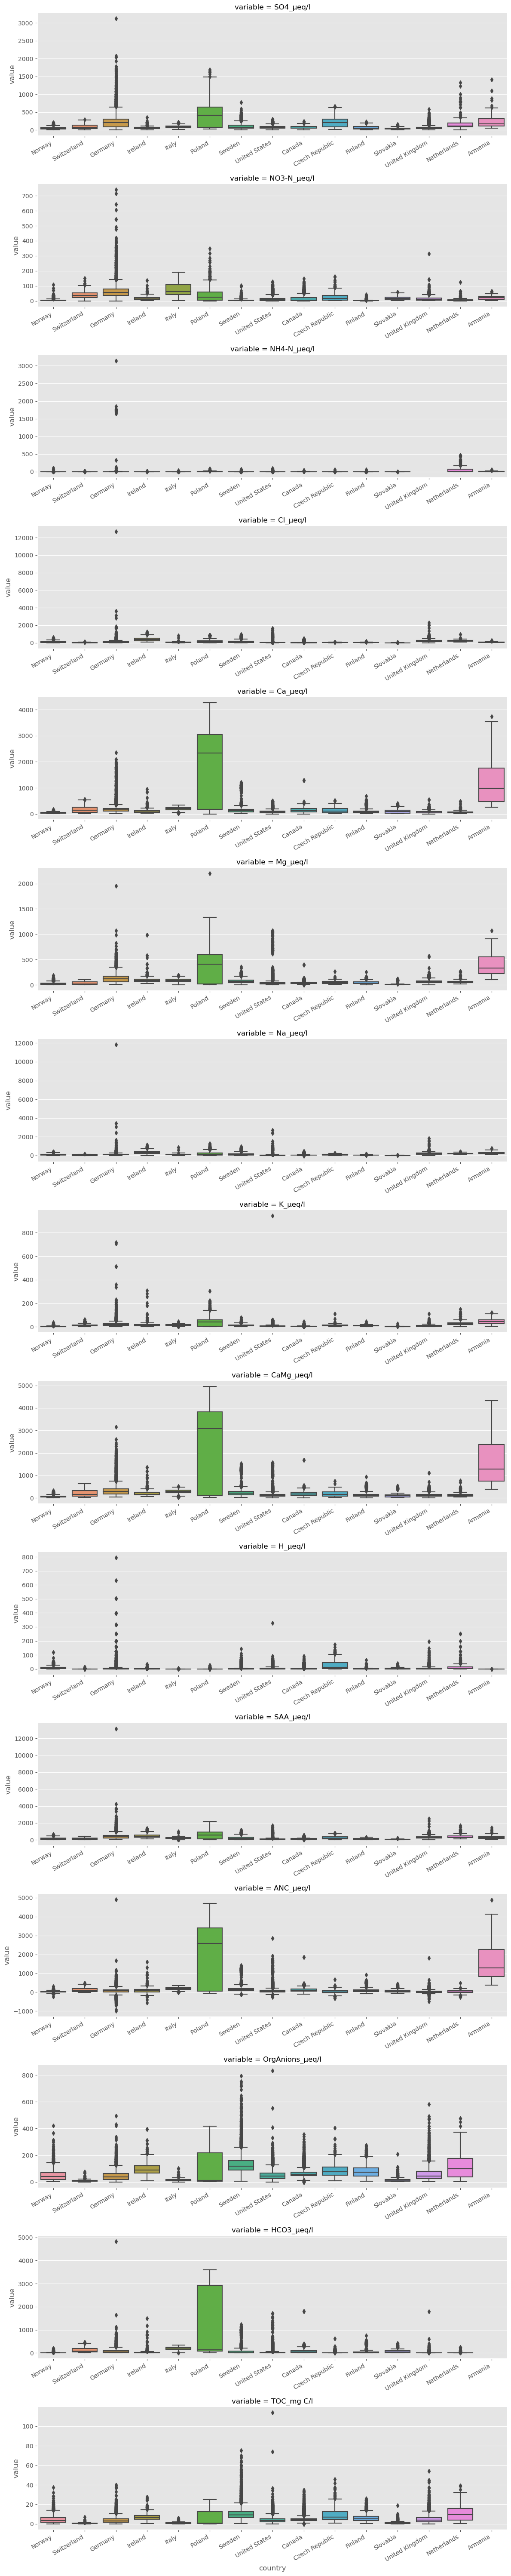

In [8]:
# Join country attribute
df = pd.merge(wc_df, stn_df[["station_id", "country"]], how="left", on="station_id")

# Pars to plot
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]

# Reshape
df = df[["country"] + pars]
df = df.melt(id_vars=["country"])

# Plot
g = sn.catplot(
    data=df,
    x="country",
    y="value",
    row="variable",
    kind="box",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
g.set_xticklabels(rotation=30, ha="right")
plt.tight_layout()

## 4. Data cleaning

The distributions above highlight potential issues with the raw data. In a comment [here](https://github.com/JamesSample/icpw2/issues/4#issuecomment-1522126141), Rolf suggested calculating the ion balance and discarding samples where the difference is >20%. However, we have already calculated bicarbonate using the ion balance ([here](https://github.com/JamesSample/icpw2/issues/3#issuecomment-1521604595)), so the ion balance in this dataset is by definition zero, *except in cases where the estimate for HCO3 is initially negative* (in which case it is [set back to zero](https://github.com/JamesSample/icpw2/blob/e0192bc439618ed9d3c10c7adbc1d28836c6a456/thematic_report_2023/utils.py#L477)). See the comment [here](https://github.com/JamesSample/icpw2/issues/4#issuecomment-1523093566) for further discussion of this.

The code below estimates the ion balance as

$$IB = Ca + Mg + Na + K + HN4 + H - Cl - SO4 - NO3 - OrgAnions - HCO3$$

and discards samples where the difference is greater than 20% of the summed cations. Note that because of the way we have calculated HCO3, this corresponds to samples where the initial HCO3 estimate was strongly negative.

In [9]:
# Filter samples based on ion balance
for par in ["NH4-N_µeq/l", "K_µeq/l"]:
    if par in wc_df.columns:
        wc_df[par + "_temp"] = wc_df[par].fillna(0)
    else:
        wc_df[par + "_temp"] = 0

wc_df["Cations_µeq/l"] = (
    wc_df["Ca_µeq/l"]
    + wc_df["Mg_µeq/l"]
    + wc_df["Na_µeq/l"]
    + wc_df["K_µeq/l_temp"]
    + wc_df["NH4-N_µeq/l_temp"]
    + wc_df["H_µeq/l"]
)
wc_df["Anions_µeq/l"] = (
    wc_df["Cl_µeq/l"]
    + wc_df["SO4_µeq/l"]
    + wc_df["NO3-N_µeq/l"]
    + wc_df["OrgAnions_µeq/l"]
    + wc_df["HCO3_µeq/l"]
)

wc_df["IonBal_µeq/l"] = wc_df["Cations_µeq/l"] - wc_df["Anions_µeq/l"]
wc_df["Zdiff_pct"] = 100 * wc_df["IonBal_µeq/l"] / wc_df["Cations_µeq/l"]
del wc_df["K_µeq/l_temp"], wc_df["NH4-N_µeq/l_temp"]

print("Total number of water samples:", len(wc_df))
print(
    "Number for which ion balance cannot be calculated:",
    len(wc_df[pd.isna(wc_df["Zdiff_pct"])]),
)
print(
    "Number with ion balance difference >20%", len(wc_df[wc_df["Zdiff_pct"].abs() > 20])
)
print(
    "Number with ion balance difference ≤20%",
    len(wc_df[wc_df["Zdiff_pct"].abs() <= 20]),
)

# Remove data with suspicious ion balance
wc_df = wc_df[wc_df["Zdiff_pct"].abs() <= 20]
del wc_df["Cations_µeq/l"], wc_df["Anions_µeq/l"], wc_df["IonBal_µeq/l"], wc_df["Zdiff_pct"]

Total number of water samples: 96823
Number for which ion balance cannot be calculated: 17036
Number with ion balance difference >20% 20092
Number with ion balance difference ≤20% 59695


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


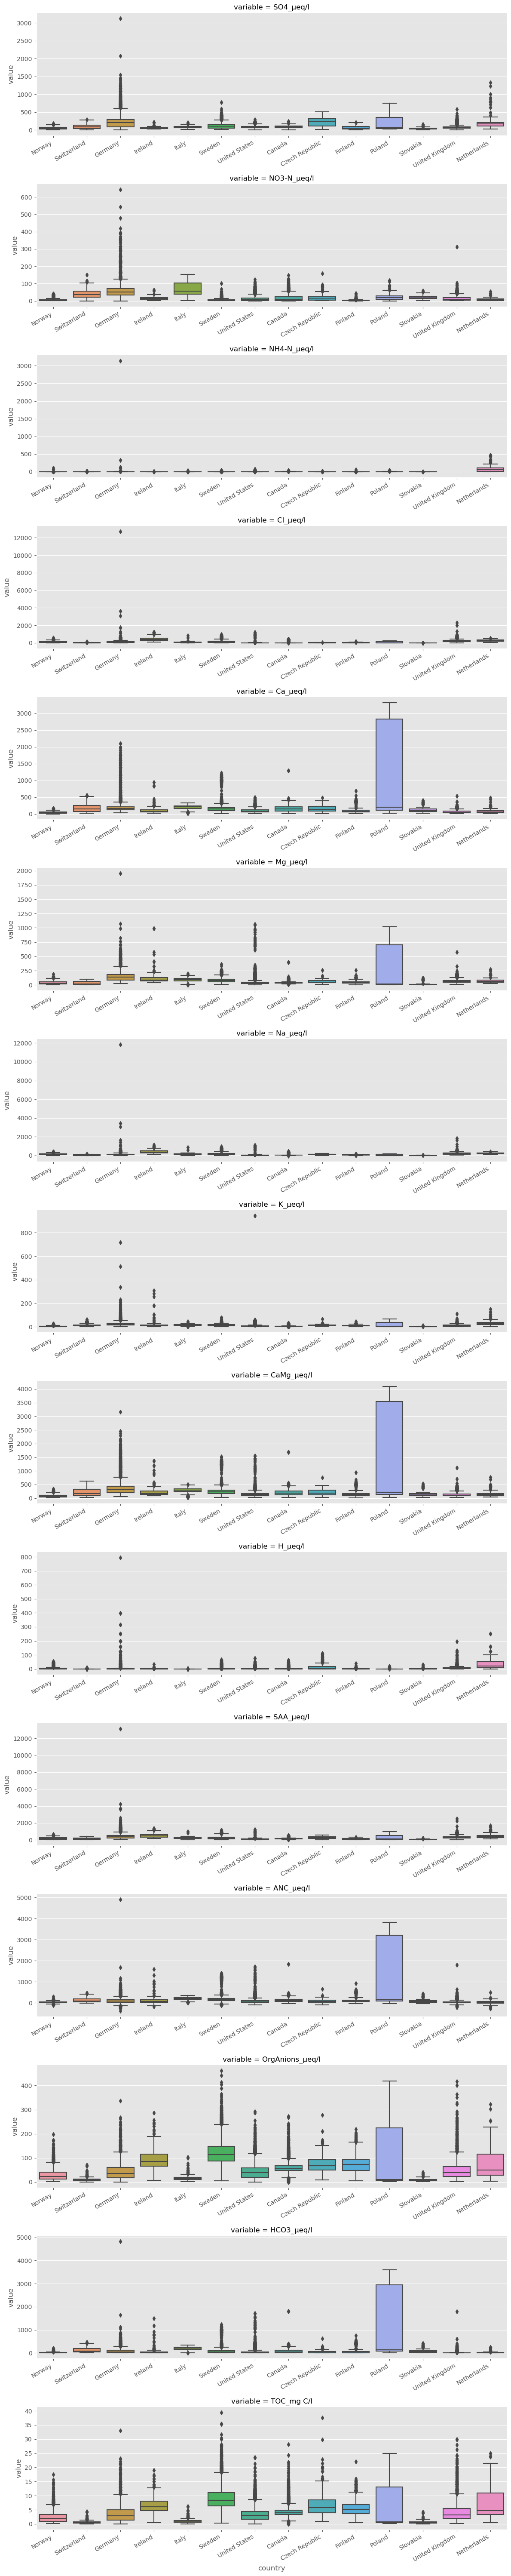

In [10]:
# Updated distribution plots
# Join country attribute
df = pd.merge(wc_df, stn_df[["station_id", "country"]], how="left", on="station_id")

# Pars to plot
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]

# Reshape
df = df[["country"] + pars]
df = df.melt(id_vars=["country"])

# Plot
g = sn.catplot(
    data=df,
    x="country",
    y="value",
    row="variable",
    kind="box",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
g.set_xticklabels(rotation=30, ha="right")
plt.tight_layout()

In [11]:
# Save for speed later
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df.to_csv(csv_path, index=False, encoding="utf-8")

## 5. Aggregate to annual medians

In [12]:
# Read saved data
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")

# Annual medians by station
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()
ann_df.head()

,station_id,year,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,...,Ca_µeq/l,Mg_µeq/l,Na_µeq/l,K_µeq/l,CaMg_µeq/l,H_µeq/l,SAA_µeq/l,ANC_µeq/l,OrgAnions_µeq/l,HCO3_µeq/l
0,101,1990,1.070,1.6,0.200,0.28,NaN,60.0,1.18,4.00,...,53.393214,23.033893,51.327110,5.114828,76.427106,3.715352,132.695782,0.173262,21.156246,0.0
1,101,1992,1.105,1.5,0.235,0.28,NaN,39.0,1.19,3.85,...,55.139721,23.033893,51.762086,6.009923,78.173613,2.727214,125.252150,10.693472,26.698693,0.0
2,101,1993,1.030,1.5,0.220,0.24,NaN,27.0,1.28,3.60,...,51.397206,19.743337,55.676865,5.626311,71.140542,2.754229,119.190014,13.253704,40.592243,0.0
3,101,1994,1.140,1.4,0.260,0.27,NaN,64.0,1.34,4.00,...,56.886228,22.211254,58.286718,6.649276,79.097481,1.584893,127.340225,16.693251,40.859667,0.0
4,101,1995,1.110,1.3,0.190,0.25,NaN,38.0,1.22,3.40,...,55.389222,20.565976,53.067012,4.859086,75.955197,1.698244,110.170462,23.710834,34.691467,0.0


## 6. Site selection

In [13]:
# Pars to consider
df = ann_df.copy()
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]
df = df[["station_id", "year"] + pars]

# Melt to long format
df = pd.melt(df, id_vars=["station_id", "year"])
df.dropna(how="any", inplace=True)
df.head()

,station_id,year,variable,value
0,101,1990,SO4_µeq/l,83.279895
1,101,1992,SO4_µeq/l,80.156899
2,101,1993,SO4_µeq/l,74.951906
3,101,1994,SO4_µeq/l,83.279895
4,101,1995,SO4_µeq/l,70.787911


In [14]:
# Define selection criteria
n_start_thresh = 1  # Number of annual values in first 5 years
n_end_thresh = 1  # Number of annual values in last 5 years
prop_thresh = 0.65  # Proportion of total years with data
periods = ((1990, 2020), (1990, 2004), (1998, 2012), (2006, 2020))

# Dict for results
inc_dict = {
    "station_id": [],
    "variable": [],
    "period": [],
    "include": [],
}

# Loop over time series
for stn_id in df["station_id"].unique():
    # Loop over variables
    for par in df["variable"].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index("year", inplace=True)
        del stn_par_df["station_id"], stn_par_df["variable"]

        for period in periods:
            st_yr, end_yr = period
            years = range(st_yr, end_yr + 1)
            n_yrs = len(years)
            yrs_thresh = round(n_yrs * prop_thresh)
            years_df = pd.DataFrame(index=years)

            # Join by year (=> annual series with no gaps)
            stn_par_yr_df = years_df.join(stn_par_df)

            if pd.isna(stn_par_yr_df["value"]).all().all():
                # Not suitable
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["period"].append(f"{st_yr}-{end_yr}")
                inc_dict["include"].append(0)

            else:
                n_start = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index < (st_yr + 5)]["value"]
                ).sum()
                n_end = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index > (end_yr - 5)]["value"]
                ).sum()
                non_missing = pd.notnull(stn_par_yr_df["value"]).sum()

                if (
                    (n_start >= n_start_thresh)
                    and (n_end >= n_end_thresh)
                    and (non_missing >= yrs_thresh)
                ):
                    # Include
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(1)

                else:
                    # Not suitable
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(0)

# Build df
inc_df = pd.DataFrame(inc_dict)

# Unstack to 'wide'
inc_df.set_index(["station_id", "variable", "period"], inplace=True)
inc_df = inc_df.unstack("variable")
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Join station details
inc_df = pd.merge(
    inc_df,
    stn_df[["station_id", "station_code", "station_name", "country"]],
    how="left",
    on="station_id",
)

inc_df.to_csv("./data/selection_criteria_by_station-par-period.csv", index=False)